<a href="https://colab.research.google.com/github/OmarMoghazy/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import random
import math

import os

import matplotlib.pyplot as plt

from PIL import Image

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import scipy.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_train = []
img_test = []
img_valid = []

gt_train = []
gt_test = []
gt_valid = []

for i in range(1, 51):
  image_temp = Image.open('drive/MyDrive/data/images/test/i ('+str(i)+').jpg')
  img_train.append(np.array(image_temp))
  mat = scipy.io.loadmat('drive/MyDrive/data/groundTruth/test/j ('+str(i)+').mat')
  temp = []
  for i in range(mat['groundTruth'][0].size):
    for j in range(mat['groundTruth'][0][i][0][0].size):
      temp.append(np.array(mat['groundTruth'][0][i][0][0][j]))
  gt_train.append(temp)

In [ ]:
def el3abat(img, ground_truth):
  fig,axes = plt.subplots(1, 1+len(ground_truth))
  fig.set_size_inches((30,10))
  axes[0].imshow(img)
  for i, gt in zip(range(len(ground_truth)) ,ground_truth):
    axes[i+1].imshow(gt)

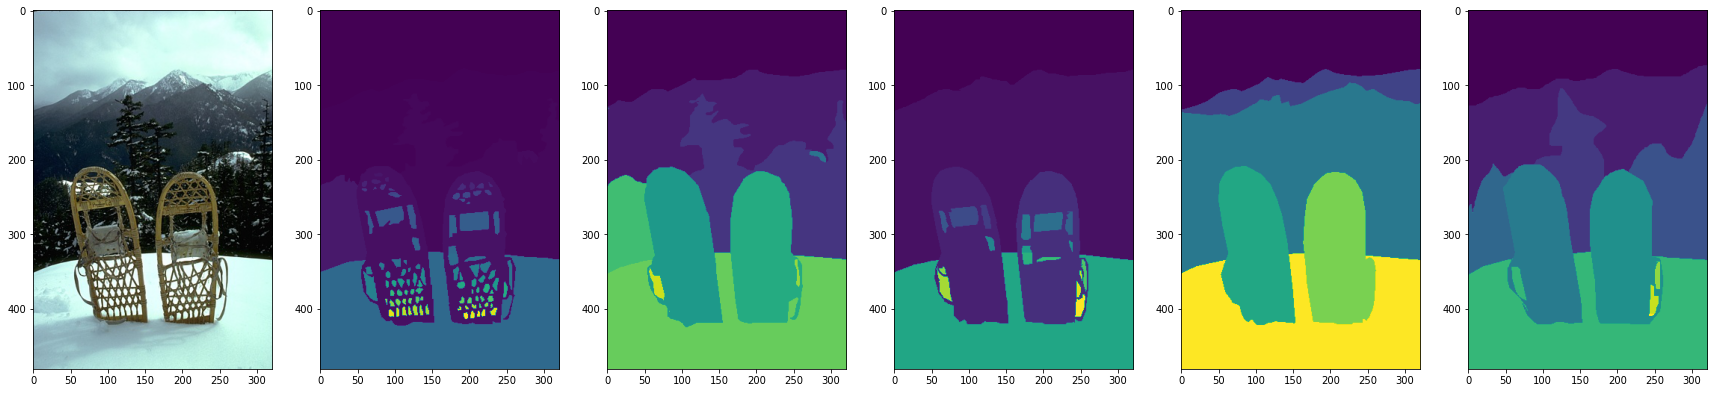

In [ ]:
el3abat(img_train[0], gt_train[0])

In [ ]:
def _KMeans(image, k):
  clustering = np.zeros(image.shape[0])

  indices = np.random.choice(image.shape[0], k, replace=False)  

  centroids = image[indices]
  for i in range(10):
    # cluster assignment
    for n in range(len(image)):
      distances = []
      for row in centroids:
        distances.append(((image[n]-row)**2).sum())
      min_value = min(distances)
      clustering[n] = distances.index(min_value)
    
    # centroid update
    clusters = []
    for i in range(k):
      clusters.append( np.where(clustering == i)[0] )

    new_centroids = []
    for i, c in zip(range(k), clusters):
      new_centroids.append(np.mean(image[c], axis=0))

    if np.sum(np.array(new_centroids) - np.array(centroids)) == 0:
      break
    centroids = new_centroids

  return clustering, centroids

In [ ]:
def evaluate(cluster_labels, gt, k):
  gt = gt - 1
  
  clusters = []
  for i in range(k):
    clusters.append( np.where(cluster_labels == i)[0] )
  # for c in clusters:
  #   print(c.shape)

  ground_truth = []
  for i in range(len(np.unique(gt))):
    ground_truth.append( np.where(gt == i)[0] )
  # for g in ground_truth:
  #   print(g.shape)
    
  fmeasure = 0
  conditional_entropy = 0
  for c in clusters:
    l = []
    for i in range(len(ground_truth)):
      l.append(len(list(set(c).intersection(ground_truth[i]))))
    maximum = max(l)
    max_idx = l.index(maximum)

    terms = []
    for aaa in l:
      p_temp = aaa/len(c) if len(c) > 0 else 0
      terms.append(0 if p_temp == 0 else p_temp * math.log(p_temp, 2))

    conditional_entropy += len(c) / len(cluster_labels) * (-1 * (np.sum(terms)))

    purityi = maximum / len(c) if len(c) > 0 else 0

    recalli = maximum / len(ground_truth[max_idx])
    fmeasure += (2 * purityi * recalli) / (purityi + recalli) * (1/k) if maximum > 0 else 0
  return fmeasure, conditional_entropy

In [ ]:
df = pd.DataFrame({"F-Measures" : [], "Conditional Entropy" : [], "k" : [], "n" : []})

In [ ]:
for n, image in zip(range(17, len(img_train)) ,img_train[17:]):
  # fig, axes = plt.subplots(1, 5)
  # fig.set_size_inches((30,10))
  
  fmeasures = []
  c_entropies = []
  ks = []
  for i,k in zip(range(5), [3,5,7,9,11]):
    image = np.array(image)
    x, y, z = image.shape
    image_2d = image.reshape(x*y, z)

    # our implementation
    cluster_labels, cluster_centers = _KMeans(image_2d, k)
    saveme = np.zeros(( len(cluster_labels), 3 ))
    for sigh in range(len(cluster_labels)):
      saveme[sigh] = cluster_centers[int(cluster_labels[sigh])]
    saveme = Image.fromarray((saveme).reshape(x,y,z).astype(np.uint8))
    saveme.save("drive/MyDrive/data/output by TEAM/"+ str(n) +" k" + str(k) +".jpg")

    # # built in
    # kmeans_cluster = KMeans(n_clusters=k)
    # kmeans_cluster.fit(image_2d/255)
    # cluster_centers = kmeans_cluster.cluster_centers_
    # cluster_labels = kmeans_cluster.labels_
    # segmented_image = np.array(cluster_centers[np.array(cluster_labels)].reshape(x, y, z))
    # # axes[i].imshow(segmented_image*255)
    # Image.fromarray((segmented_image*255).astype(np.uint8)).save("drive/MyDrive/data/"+ str(n) +" k" + str(k) +".jpg")
    # # plt.imshow(cluster_labels.reshape(x,y))


    # evaluation
    count = 1
    for gt in gt_train[n]:
          fmeasure, c_entropy = evaluate(cluster_labels, gt.flatten(), k)
          fmeasures.append(fmeasure)
          c_entropies.append(c_entropy)
          ks.append(k)
          # print("M", count)
          # count = count+1
          # print("Fmeasure =", fmeasure)
          # print("Conditional Entropy =", c_entropy)
          # print()

  df_temp = pd.DataFrame({"F-Measures" : fmeasures, "Conditional Entropy" : c_entropies, "k" : ks, "n" : n})
  df = pd.concat([df, df_temp], axis=0)
  if n % 5 == 4:
    df = df.reset_index().drop('index', 1)
    df.to_excel("drive/MyDrive/data/evaluation/evaluation_"+ str(n/5 + 1) +".xlsx")

# Bonus

In [ ]:
image = img_train[0]

image = np.array(image)
x, y, z = image.shape
image_2d = image.reshape(x*y, z)

space_diff = []

for i in range(image.shape[0]):
  for j in range(image.shape[1]):
    x = i*image.shape[0]
    y = j
    space_diff.append(np.sqrt((x**2 + y**2)))

# normalize between 0 and 255 like rgb

space_diff = np.array(space_diff)

space_diff = 255 * (space_diff - min(space_diff)) / (max(space_diff) - min(space_diff))

# image_2d = np.hstack((image_2d, space_diff))
space_diff = np.atleast_2d(space_diff)
image_2d = np.concatenate([image_2d,space_diff.T], axis=1)
# for i in range(image2d.shape[0])):
#   image_2d[i]




(5, 4)


In [ ]:
ks = [3,5,7,9,11]
df = pd.DataFrame({"F-Measures" : [], "Conditional Entropy" : [], "k" : [], "n" : []})
for k in ks:
  x, y, z = image.shape
  cluster_labels, cluster_centers = _KMeans(image_2d, k)

  cluster_centers = np.array(cluster_centers)
  cluster_centers = cluster_centers[:,:3]

  saveme = np.zeros(( len(cluster_labels), 3 ))
  for sigh in range(len(cluster_labels)):
    saveme[sigh] = cluster_centers[int(cluster_labels[sigh]), :3]
  saveme = Image.fromarray((saveme).reshape(x,y,z).astype(np.uint8))
  saveme.save("drive/MyDrive/data/Bonus/BONUS KMEANS_k"+str(k)+".jpg")

  count = 1
  fmeasures = []
  c_entropies = []

  for gt in gt_train[0]:
    fmeasure, c_entropy = evaluate(cluster_labels, gt.flatten(), k)
    fmeasures.append(fmeasure)
    c_entropies.append(c_entropy)
    # print("M", count)
    # count = count+1
    # print("Fmeasure =", fmeasure)
    # print("Conditional Entropy =", c_entropy)
    # print()

  df_temp = pd.DataFrame({"F-Measures" : fmeasures, "Conditional Entropy" : c_entropies, "k" : k, "n" : 0})
  df = pd.concat([df, df_temp], axis=0)


df.to_excel("drive/MyDrive/data/evaluation/evaluation_BONUS_KMEANS.xlsx")

# print(space_diff)

# for i in range(image.shape[]):


(3, 4)
M 1
Fmeasure = 0.7598415358876042
Conditional Entropy = 1.8492279605589133

M 2
Fmeasure = 0.76013951808631
Conditional Entropy = 1.54392510718824

M 3
Fmeasure = 0.8652820249075901
Conditional Entropy = 1.195140892303673

M 4
Fmeasure = 0.8613273877403789
Conditional Entropy = 1.1689900733414211

M 5
Fmeasure = 0.7598115947791562
Conditional Entropy = 1.6881928764571823

(5, 4)
M 1
Fmeasure = 0.7432335289319142
Conditional Entropy = 1.4541362932936073

M 2
Fmeasure = 0.735319169294858
Conditional Entropy = 1.194787556909414

M 3
Fmeasure = 0.7074625495571198
Conditional Entropy = 0.9238215092463202

M 4
Fmeasure = 0.7062991598606053
Conditional Entropy = 0.9091842605907835

M 5
Fmeasure = 0.6993033062605222
Conditional Entropy = 1.3459127407540883

(7, 4)
M 1
Fmeasure = 0.6096467254658946
Conditional Entropy = 1.4202818296441464

M 2
Fmeasure = 0.6034806664141361
Conditional Entropy = 1.167260173623213

M 3
Fmeasure = 0.5934982570719893
Conditional Entropy = 0.8710734549168149
